# The Instacart competition
Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample dataset of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was participants to **predict which previously purchased products will be in a user’s next order**.


## Problem definition
The data that Instacart opened up include orders of 200,000 Instacart users with each user having between 4 and 100 orders. Instacart indicates each order in the data as prior, train or test. Prior orders describe the **past behaviour** of a user while train and test orders regard the **future behaviour that we need to predict**. 

As a result, we want to predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders). 

For the train orders Instacart reveals the results (i.e., the reordered products) while for the test orders we do not have this piece of information. Moreover, the future order of each user can be either train or test meaning that each user will be either a train or a test user. 


Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order. The goal is to predict which of these products will be in a user's future order. 

This is a **classification problem** because we need to predict whether each pair of user and product is a reorder or not. 

As a result we come up and calculate various **predictor variables (X)** that will describe the characteristics of a product and the behaviour of a user regarding one or multiple products. We will do so by analysing the prior orders of the dataset. We will then use the train users to create a predictive model and the test users to make our actual prediction. 
## Method
Our method includes the following steps:
1. <b>Import and reshape data</b>: This step includes loading CSV files into pandas DataFrames, and create a supportive table.
2. <b>Create predictor variables</b>: This step includes identifying and calculating predictor variables (aka features) from the initial datasets provided by Instacart. 
3. <b>Create train and test DataFrames</b>: In this step we create two distinct pandas DataFrames that will be used in the creation and the use of the predictive model.
4. <b>Create predictive model (fit)</b>: In this step we train a predictive model through the train dataset.
5. <b>Apply predictive model (predict)</b>: This step includes applying the model to predict the 'reordered' variable for the test dataset.

# 1. Import and Reshape Data 
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.**

## 1.1 Import the required packages


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
matplotlib.use('Agg')
#matplotlib.style.use('ggplot')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

## 1.2 Load data from the CSV files
Instacart provides 6 CSV files, which we have to load into Python.**

In [2]:
orders = pd.read_csv('data/orders.csv' )
order_products_train = pd.read_csv('data/order_products__train.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
products = pd.read_csv('data/products.csv')
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


**This step results in the following DataFrames:**
* <b>orders</b>: This table includes all orders, namely prior, train, and test. It has single primary key (<b>order_id</b>).
* <b>order_products_train</b>: This table includes training orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>order_products_prior </b>: This table includes prior orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>products</b>: This table includes all products. It has a single primary key (<b>product_id</b>)
* <b>aisles</b>: This table includes all aisles. It has a single primary key (<b>aisle_id</b>)
* <b>departments</b>: This table includes all departments. It has a single primary key (<b>department_id</b>)

We will now visualize the first rows of these tables : 

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## 1.3 Create a DataFrame with the orders and the products that have been purchased on prior orders (op)
We create a new DataFrame, named <b>op</b> which merges the DataFrames <b>orders</b> and <b>order_products_prior</b>. Bear in mind that <b>order_products_prior</b> DataFrame includes only prior orders, so the new DataFrame <b>op</b>  will contain only these observations as well. Towards this end, we use pandas' merge function with how='inner' argument, which returns records that have matching values in both DataFrames. 


In [8]:
#Merge the orders DF with order_products_prior by their order_id, we keep only these rows with order_id that they are appear on both DFs
op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
5,2398795,1,prior,2,3,7,15.0,196,1,1
6,2398795,1,prior,2,3,7,15.0,10258,2,0
7,2398795,1,prior,2,3,7,15.0,12427,3,1
8,2398795,1,prior,2,3,7,15.0,13176,4,0
9,2398795,1,prior,2,3,7,15.0,26088,5,1


The table contains for all the customers **(user_id)**: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the orders **(order_id)** that they have placed accompanied with: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the products **(product_id)** that have been bought in each order

# 2. Create Predictor Variables
We are now ready to identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:
* <b>User predictors</b> describing the behavior of a user e.g. total number of orders of a user.
* <b>Product predictors</b> describing characteristics of a product e.g. total number of times a product has been purchased.
* <b>User & product predictors</b> describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

## 2.1 Create user predictors
We create the following predictors:
- 2.1.1 Number of orders per customer
- 2.1.2 How frequent a customer has reordered products
- 2.1.3 Find users favorite department

### 2.1.1 Number of orders per customer
We calculate the total number of placed orders per customer. We create a **user** DataFrame to store the results.

In [9]:
## First approach in one step:
# Create distinct groups for each user, identify the highest order number in each group, save the new column to a DataFrame
user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders').reset_index()
user.head(10)

## Second approach in two steps: 
#1. Save the result as DataFrame with Double brackets --> [[ ]] 
#user = op.groupby('user_id')[['order_number']].max()
#2. Rename the label of the column
#user.columns = ['u_total_orders']
#user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4
5,6,3
6,7,20
7,8,3
8,9,3
9,10,5


### 2.1.2 How frequent a customer has reordered products

This feature is a ratio which shows for each user in what extent has products that have been reordered in the past: <br>
So we create the following ratio: <br>

<img src="https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id)=&space;\frac{total\&space;times\&space;of\&space;reorders}{total\&space;number\&space;of\&space;purchased\&space;products\&space;from\&space;all\&space;baskets}" title="probability\ reordered\ (user\_id)= \frac{total\ times\ of\ reorders}{total\ number\ of\ purchased\ products\ from\ all\ baskets}" />

The nominator is a counter for all the times a user has reordered products (value on reordered=1), the denominator is a counter of all the products that have been purchased on all user's orders (reordered=0 & reordered=1).



In [10]:
u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio').reset_index()
u_reorder.head(10)

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378
5,6,0.142857
6,7,0.669903
7,8,0.265306
8,9,0.236842
9,10,0.342657


The new feature will be merged with the user DataFrame (section 2.1.1) which keep all the features based on users.

### 2.1.3 Users favorite department
We will find the favorite department of each user :

In [11]:
comb = orders.merge(order_products_prior, on='order_id', how='inner')
comb =comb.drop(['order_number','order_dow','eval_set','order_hour_of_day','days_since_prior_order','add_to_cart_order','reordered'],axis=1)

comb2 = comb.merge(products ,on = 'product_id', how = 'left')
comb2 = comb2.drop(['aisle_id','product_name'], axis = 1)



comb2.head()

,order_id,user_id,product_id,department_id
0,2539329,1,196,7
1,2539329,1,14084,16
2,2539329,1,12427,19
3,2539329,1,26088,19
4,2539329,1,26405,17


In [12]:
users_dep = comb2.groupby('user_id')['department_id'].value_counts().to_frame('how_many_bought')
users_dep = users_dep.reset_index()
users_dep

,user_id,department_id,how_many_bought
0,1,19,22
1,1,7,13
2,1,16,13
3,1,4,5
4,1,14,3
...,...,...,...
2232784,206209,20,6
2232785,206209,9,3
2232786,206209,1,2
2232787,206209,12,2


In [13]:
bestdep = users_dep.groupby('user_id')['how_many_bought'].max().to_frame('how_many_bought')
bestdep = bestdep.reset_index()
bestdep

,user_id,how_many_bought
0,1,22
1,2,48
2,3,38
3,4,3
4,5,19
...,...,...
206204,206205,14
206205,206206,76
206206,206207,52
206207,206208,197


In [14]:
favorite_dep = users_dep.merge(bestdep,how = 'inner')
favorite_dep = favorite_dep.drop_duplicates(subset = ['user_id'])
favorite_dep = favorite_dep.drop('how_many_bought',axis = 1)
favorite_dep

,user_id,department_id
0,1,19
1,2,16
2,3,4
3,4,1
5,5,4
...,...,...
217965,206205,16
217966,206206,1
217967,206207,16
217968,206208,4


In [15]:
user = user.merge(u_reorder, on='user_id', how='left')
user.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


In [16]:
user = user.merge(favorite_dep , on= 'user_id', how = 'inner')
user

,user_id,u_total_orders,u_reordered_ratio,department_id
0,1,10,0.694915,19
1,2,14,0.476923,16
2,3,12,0.625000,4
3,4,5,0.055556,1
4,5,4,0.378378,4
...,...,...,...,...
206204,206205,3,0.250000,16
206205,206206,67,0.473684,1
206206,206207,16,0.587444,16
206207,206208,49,0.707533,4


## 2.2 Create product predictors
We create the following predictors:
- 2.2.1 Number of purchases for each product
- 2.2.2 What is the probability for a product to be reordered
- 2.2.3 How many times a product placed first in the cart order
- 2.2.4 How frequently a product placed first in the cart

### 2.2.1 Number of purchases for each product
We calculate the total number of purchases for each product (from all customers).

In [17]:
# Create distinct groups for each product, count the orders, save the result for each product to a new DataFrame  
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases').reset_index()
prd.head(10)

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15
5,6,8
6,7,30
7,8,165
8,9,156
9,10,2572


### 2.2.2 What is the probability for a product to be reordered
We want to find the products which have the highest probability of being reordered.
<img src="https://latex.codecogs.com/gif.latex?\dpi{150}&space;\large&space;probability\&space;reordered\&space;(product\_id)=&space;\frac{number\&space;of\&space;reorders}{total\&space;number\&space;of\&space;orders\&space;}" title="probability\ reordered\ (product\_id)= \frac{number\ of\ reorders}{total\ number\ of\ orders\ }" />




#### 2.2.2.1 Remove products with less than 40 purchases - Filter with .shape[0]
Before we proceed to this estimation, we remove all these products that have less than 40 purchases in order the calculation of the aforementioned ratio to be meaningful.

In [18]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
5,2398795,1,prior,2,3,7,15.0,196,1,1
6,2398795,1,prior,2,3,7,15.0,10258,2,0
7,2398795,1,prior,2,3,7,15.0,12427,3,1
8,2398795,1,prior,2,3,7,15.0,13176,4,0
9,2398795,1,prior,2,3,7,15.0,26088,5,1


#### 2.2.2.2 Group products, calculate the mean of reorders

We will calculate the reorder probability. In the reorder data frame, the reordered column indicates that a product has been reordered when the value is 1.

We calculate the ratio for each product. The aggregation function is limited to column 'reordered' and it calculates the mean value of each group.

In [19]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio').reset_index()
p_reorder.head(10)

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030
5,9,0.525641
6,10,0.506998
7,11,0.567308
8,12,0.512195
9,18,0.598540


### 2.2.3 How many times a product placed first in the cart 

In [20]:
firsttocart = op[op['add_to_cart_order'] == 1 ]

In [21]:
firsttocart.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
5,2398795,1,prior,2,3,7,15.0,196,1,1
11,473747,1,prior,3,3,12,21.0,196,1,1
16,2254736,1,prior,4,4,7,29.0,196,1,1
21,431534,1,prior,5,4,15,28.0,196,1,1


In [22]:
p_firstincart = firsttocart.groupby('product_id')['add_to_cart_order'].count().to_frame('p_placed_first_in_cart')


In [23]:
p_firstincart= p_firstincart.reset_index()

In [24]:
p_firstincart.head()

,product_id,p_placed_first_in_cart
0,1,272
1,2,11
2,3,43
3,4,14
4,7,3


### 2.2.4 How frequently a product placed first in the cart

In [25]:
p_placed_incart = op.groupby('product_id')['add_to_cart_order'].count().to_frame('p_in_cart').reset_index()
p_placed_incart.head()

,product_id,p_in_cart
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [26]:
p_ratio_incart = p_placed_incart.merge(p_firstincart , on = 'product_id', how = 'left')
p_ratio_incart['p_placed_first_in_cart'] = p_ratio_incart['p_placed_first_in_cart'].fillna(value =0)
p_ratio_incart['p_in_cart'] = p_ratio_incart['p_in_cart'].fillna(value =0)
p_ratio_incart['p_1incart_ratio'] = p_ratio_incart.p_placed_first_in_cart / p_ratio_incart.p_in_cart 
p_ratio_incart

,product_id,p_in_cart,p_placed_first_in_cart,p_1incart_ratio
0,1,1852,272.0,0.146868
1,2,90,11.0,0.122222
2,3,277,43.0,0.155235
3,4,329,14.0,0.042553
4,5,15,0.0,0.000000
...,...,...,...,...
49672,49684,9,0.0,0.000000
49673,49685,49,8.0,0.163265
49674,49686,120,11.0,0.091667
49675,49687,13,3.0,0.230769


In [27]:
del p_ratio_incart['p_in_cart'] , p_ratio_incart['p_placed_first_in_cart']
p_ratio_incart

,product_id,p_1incart_ratio
0,1,0.146868
1,2,0.122222
2,3,0.155235
3,4,0.042553
4,5,0.000000
...,...,...
49672,49684,0.000000
49673,49685,0.163265
49674,49686,0.091667
49675,49687,0.230769


### 2.2.4 Merge the new feature on prd DataFrame
The new feature will be merged with the prd DataFrame (section 2.2.1) which keep all the features based on products.

In [28]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder

prd = prd.merge(p_firstincart,on='product_id', how= "left")

prd = prd.merge(p_ratio_incart, on='product_id', how = "left")



In [29]:
prd.head()

,product_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio
0,1,1852,0.613391,272.0,0.146868
1,2,90,0.133333,11.0,0.122222
2,3,277,0.732852,43.0,0.155235
3,4,329,0.446809,14.0,0.042553
4,5,15,NaN,NaN,0.000000


#### 2.2.4.1 Fill NaN values
There are product with NaN values. This regards the products that have been purchased less than 40 times from all users and were not included in the p_reorder DataFrame. **As we performed a left join with prd DataFrame, all the rows with products that had less than 40 purchases from all users, will get a NaN value.**

For these products we their NaN value with zero (0):

In [30]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio
0,1,1852,0.613391,272.0,0.146868
1,2,90,0.133333,11.0,0.122222
2,3,277,0.732852,43.0,0.155235
3,4,329,0.446809,14.0,0.042553
4,5,15,0.000000,NaN,0.000000


In [31]:
prd['p_placed_first_in_cart'] = prd['p_placed_first_in_cart'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio
0,1,1852,0.613391,272.0,0.146868
1,2,90,0.133333,11.0,0.122222
2,3,277,0.732852,43.0,0.155235
3,4,329,0.446809,14.0,0.042553
4,5,15,0.000000,0.0,0.000000


In [32]:
del p_firstincart

## 2.3 Create user-product predictors
We create the following predictors:
- 2.3.1 How many times a user bought a product
- 2.3.2 How frequently a customer bought a product after its first purchase
- 2.3.3 How many times a customer bought a product on its last 5 orders
- 2.3.4 How many times a user placed a product first in cart


### 2.3.1 How many times a user bought a product
We create different groups that contain all the rows for each combination of user and product. We save the results on new **uxp** DataFrame.

In [33]:
# Create distinct groups for each combination of user and product, count orders, save the result for each user X product to a new DataFrame 
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought').reset_index()
uxp.head(10)

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3
5,1,13176,2
6,1,14084,1
7,1,17122,1
8,1,25133,8
9,1,26088,2


### 2.3.2 How frequently a customer bought a product after its first purchase
This ratio is a metric that describes how many times a user bought a product out of how many times she had the chance to a buy it (starting from her first purchase of the product):

<img src="https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id\&space;,&space;product\_id)&space;=&space;\frac{Times\_Bought\_N}{Order\_Range\_D}" title="\large probability\ reordered\ (user\_id\ , product\_id) = \frac{Times\_Bought\_N}{Order\_Range\_D}" />

* Times_Bought_N = Times a user bought a product
* Order_Range_D = Total orders placed since the first user's order of a product

To clarify this, we examine the use with user_id:1 and the product with product_id:13032. User 1 has made 10 orders in total.She has bought the product 13032 **for first time in her 2nd order** and she has bought the same product 3 times in total. The user was able to buy the product 9 times (starting from her 2nd order until her last order). As a result, she has bought it 3 out of 9 times, meaning reorder_ratio=3/9= 0,333.

The Order_Range_D variable is created using two supportive variables:
* Total_orders = Total number of orders of each user
* First_order_number = The order number where the customer bought a product for first time

In the next blocks we show how we create:
1. The numerator 'Times_Bought_N'
2. The denumerator 'Order_Range_D' with the use of the supportive variables 'total_orders' & 'first_order_number' 
3. Our final ratio 'uxp_order_ratio'

### 2.3.2.1 Calculate the numerator ('Times_Bought_N')

To answer this question we simply .groupby( ) user_id & product_id and we count the instances of order_id for each group.

In [34]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

### 2.3.2.2 Calculate the denumerator ('Order_Range_D')
To calculate the denumerator, we first calculate the total orders of each user & first order number for each user and every product purchase.

In order to calculate the total number of orders of each cutomer ('total_orders') we .groupby( ) only by the user_id, we keep the column order_number and we get its highest value with the aggregation function .mean()

In [35]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In order to calculate the order number where the user bought a product for first time ('first_order_number') we .groupby( ) by both user_id & product_id and we select the order_number column and we retrieve the .min( ) value.

In [36]:
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number').reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


We merge the first order number with the total_orders DataFrame. As total_orders refers to all users, where first_order_no refers to unique combinations of user & product

In [37]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')

span.head()

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


The denominator ('Order_Range_D') now can be created with simple operations between the columns of span DataFrame:

In [38]:
# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1

span.head()

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


### 2.3.2.3 Create the final ratio "uxp_reorder_ratio"

We merge **times** DataFrame, which contains the numerator, and **span** DataFrame, which contains the denumerator of our desired ratio. 


In [39]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


We divide the Times_Bought_N by the Order_Range_D for each user and product.

In [40]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333



We select to keep only the 'user_id', 'product_id' and the final feature 'uxp_reorder_ratio'

In [41]:
uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio.head()

,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [42]:
#Remove temporary DataFrame
del [times, first_order_no, span]

### 2.3.2.4 Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products.



In [43]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


### 2.3.3 How many times a customer bought a product on its last 5 orders
For this feature, we want to keep the last five orders for each customer and get how many times bought any product on them. To achieve this we need to:
* Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
* Keep only the last five orders for each order
* Perform a .groupby( ) on users and products to get how many times each customer bought a product.
* Create the following ratio:

![](https://latex.codecogs.com/gif.latex?times%5C%20last%20%5C5%5C%20%28of%5C%20a%5C%20purchased%5C%20product%5C%20from%5C%20a%5C%20user%29%3D%5Cfrac%7BTimes%5C%20a%5C%20user%5C%20bought%5C%20a%5C%20product%5C%20on%5C%20its%5C%20last%5C%205%5C%20orders%7D%7BTotal%5C%20orders%5C%20%3D5%7D)

#### 2.3.3.1 Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
In this step we show how we create a reverse order_number for each customer. <br>
Have a look at the orders of customer 1 (user_id == 1)

In [44]:
op[op.user_id==1].head(45)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
5,2398795,1,prior,2,3,7,15.0,196,1,1
6,2398795,1,prior,2,3,7,15.0,10258,2,0
7,2398795,1,prior,2,3,7,15.0,12427,3,1
8,2398795,1,prior,2,3,7,15.0,13176,4,0
9,2398795,1,prior,2,3,7,15.0,26088,5,1


### Our goal is a to create a new column ('order_number_back') which indicates the last order as first, the second from the end as second and so on. To achieve this, we get the highest order_number (max) for user_id==1 and we subtract the order_number of each order from it. 

### In the next code block we perform the same calculations for all users. We .groupby( ) op by the user_id and we select the column order_number. With .transform(max) we request to get the highest number of the column order_number for each group & with minus (-) op.order_number we substract the order_number of each row. Finally we add 1 for the reason mentioned above.

> .transform( ) perform some group-specific computations and return a like-indexed object. 

In [45]:
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
1,2539329,1,prior,1,2,8,NaN,14084,2,0,10
2,2539329,1,prior,1,2,8,NaN,12427,3,0,10
3,2539329,1,prior,1,2,8,NaN,26088,4,0,10
4,2539329,1,prior,1,2,8,NaN,26405,5,0,10
5,2398795,1,prior,2,3,7,15.0,196,1,1,9
6,2398795,1,prior,2,3,7,15.0,10258,2,0,9
7,2398795,1,prior,2,3,7,15.0,12427,3,1,9
8,2398795,1,prior,2,3,7,15.0,13176,4,0,9
9,2398795,1,prior,2,3,7,15.0,26088,5,1,9


Check that the formula has been applied to all users. Here we check the new column for a random user (user_id== 7):

In [46]:
op[op.user_id==7].head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
411,2565571,7,prior,1,3,9,NaN,45628,1,0,20
412,2565571,7,prior,1,3,9,NaN,39275,2,0,20
413,2565571,7,prior,1,3,9,NaN,6361,3,0,20
414,2565571,7,prior,1,3,9,NaN,45066,4,0,20
415,2565571,7,prior,1,3,9,NaN,13249,5,0,20
416,2565571,7,prior,1,3,9,NaN,31683,6,0,20
417,2565571,7,prior,1,3,9,NaN,519,7,0,20
418,2565571,7,prior,1,3,9,NaN,37999,8,0,20
419,2565571,7,prior,1,3,9,NaN,49508,9,0,20
420,2565571,7,prior,1,3,9,NaN,29871,10,0,20


#### 2.3.3.2 Keep only the last five orders for each customer
With the use of order_number_back we can now select to keep only the last five orders of each customer:

In [47]:
op5 = op[op.order_number_back <= 5]
op5.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
29,3367565,1,prior,6,2,7,19.0,196,1,1,5
30,3367565,1,prior,6,2,7,19.0,12427,2,1,5
31,3367565,1,prior,6,2,7,19.0,10258,3,1,5
32,3367565,1,prior,6,2,7,19.0,25133,4,1,5
33,550135,1,prior,7,1,9,20.0,196,1,1,4
34,550135,1,prior,7,1,9,20.0,10258,2,1,4
35,550135,1,prior,7,1,9,20.0,12427,3,1,4
36,550135,1,prior,7,1,9,20.0,25133,4,1,4
37,550135,1,prior,7,1,9,20.0,13032,5,1,4
38,3108588,1,prior,8,1,14,14.0,12427,1,1,3


#### 2.3.3.3 Perform a .groupby( ) on users and products to get how many times each customer bought every product.
Having kept the last 5 orders for each user, we perform a .groupby( ) on user_id & product_id. With .count( ) we get how many times each customer bought a product.

In [48]:
last_five = op5.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['times_last5']
last_five = last_five.reset_index()
last_five.head(10)

,user_id,product_id,times_last5
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5
5,1,35951,1
6,1,38928,1
7,1,39657,1
8,1,46149,3
9,1,49235,2


So for user_id==1, the product 196 has been ordered on all of its last five orders, where the product 35951 has been ordered only one time.

### 2.3.4 How many times a user placed a product first in cart

In [49]:
ftocart = op[op['add_to_cart_order'] == 1 ]
p_ftocart = ftocart.groupby(['user_id','product_id'])['add_to_cart_order'].count().to_frame('uxp_placed_first_in_cart')
p_ftocart = p_ftocart.reset_index()
p_ftocart.head()

,user_id,product_id,uxp_placed_first_in_cart
0,1,196,8
1,1,12427,1
2,1,49235,1
3,2,16797,1
4,2,24852,2


#### 2.3.3.5 Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame

In [50]:
uxp = uxp.merge(last_five, on=['user_id', 'product_id'], how='left')

uxp = uxp.merge(p_ftocart,on=['user_id', 'product_id'],how= 'left')
del [op5 , last_five,p_ftocart]


uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart
0,1,196,10,1.000000,5.0,8.0
1,1,10258,9,1.000000,5.0,NaN
2,1,10326,1,0.166667,NaN,NaN
3,1,12427,10,1.000000,5.0,1.0
4,1,13032,3,0.333333,2.0,NaN


#### 2.3.3.6 Fill NaN values
If you check uxp DataFrame you will notice that some rows have NaN values for our new feature. This happens as there might be products that the customer did not buy on its last five orders. For these cases, we turn NaN values into zero (0) with .fillna(0) method.

In [51]:
uxp = uxp.fillna(0)
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart
0,1,196,10,1.000000,5.0,8.0
1,1,10258,9,1.000000,5.0,0.0
2,1,10326,1,0.166667,0.0,0.0
3,1,12427,10,1.000000,5.0,1.0
4,1,13032,3,0.333333,2.0,0.0


## 2.4 Merge all features
We now merge the DataFrames with the three types of predictors that we have created (i.e., for the users, the products and the combinations of users and products).

We will start from the **uxp** DataFrame and we will add the user and prd DataFrames. 

### 2.4.1 Merge uxp with user DataFrame
Left join, ensures that the new DataFrame will have:
- all the observations of the uxp (combination of user and products) DataFrame 
- all the **matching** observations of user DataFrame with uxp based on matching key **"user_id"**

The new DataFrame as we have already mentioned, will be called **data**.

In [52]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = uxp.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart,u_total_orders,u_reordered_ratio,department_id
0,1,196,10,1.000000,5.0,8.0,10,0.694915,19
1,1,10258,9,1.000000,5.0,0.0,10,0.694915,19
2,1,10326,1,0.166667,0.0,0.0,10,0.694915,19
3,1,12427,10,1.000000,5.0,1.0,10,0.694915,19
4,1,13032,3,0.333333,2.0,0.0,10,0.694915,19


### 2.4.1 Merge data with prd DataFrame
Left join, ensures that the new DataFrame will have:
- all the observations of the data (features of userXproducts and users) DataFrame 
- all the **matching** observations of prd DataFrame with data based on matching key **"product_id"**

In [53]:
#Merge uxp & user features (the new DataFrame) with prd features
data = data.merge(prd, on='product_id', how='left')
data.head()


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart,u_total_orders,u_reordered_ratio,department_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio
0,1,196,10,1.000000,5.0,8.0,10,0.694915,19,35791,0.776480,11770.0,0.328854
1,1,10258,9,1.000000,5.0,0.0,10,0.694915,19,1946,0.713772,373.0,0.191675
2,1,10326,1,0.166667,0.0,0.0,10,0.694915,19,5526,0.652009,1047.0,0.189468
3,1,12427,10,1.000000,5.0,1.0,10,0.694915,19,6476,0.740735,1289.0,0.199043
4,1,13032,3,0.333333,2.0,0.0,10,0.694915,19,3751,0.657158,584.0,0.155692


In [54]:
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart,u_total_orders,u_reordered_ratio,department_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio
0,1,196,10,1.000000,5.0,8.0,10,0.694915,19,35791,0.776480,11770.0,0.328854
1,1,10258,9,1.000000,5.0,0.0,10,0.694915,19,1946,0.713772,373.0,0.191675
2,1,10326,1,0.166667,0.0,0.0,10,0.694915,19,5526,0.652009,1047.0,0.189468
3,1,12427,10,1.000000,5.0,1.0,10,0.694915,19,6476,0.740735,1289.0,0.199043
4,1,13032,3,0.333333,2.0,0.0,10,0.694915,19,3751,0.657158,584.0,0.155692


### 2.4.2 Delete previous DataFrames

The information from the DataFrames that we have created to store our features (op, user, prd, uxp) is now stored on **data**. 

As we won't use them anymore, we now delete them.

In [55]:
del op, user, prd, uxp


# 3. Create train and test DataFrames
## 3.1 Include information about the last order of each user

The **data** DataFrame that we have created on the previous chapter (2.4) should include two more columns which define the type of user (train or test) and the order_id of the future order.
Towards this end:
1. We select the **orders** DataFrame to keep only the future orders (labeled as "train" & "test). 
2. Keep only the columns of our desire ['eval_set', 'order_id'] <span style="color:red">**AND** </span> 'user_id' as is the matching key with our **data** DataFrame
2. Merge **data** DataFrame with the information for the future order of each customer using as matching key the 'user_id'

To filter and select the columns of our desire on orders (the 2 first steps) there are numerous approaches:

In [56]:
## First approach:
# In two steps keep only the future orders from all customers: train & test 

orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)

## Second approach (if you want to test it you have to re-run the notebook):
# In one step keep only the future orders from all customers: train & test 
#orders_future = orders.loc[((orders.eval_set=='train') | (orders.eval_set=='test')), ['user_id', 'eval_set', 'order_id'] ]
#orders_future.head(10)

## Third approach (if you want to test it you have to re-run the notebook):
# In one step exclude all the prior orders so to deal with the future orders from all customers
#orders_future = orders.loc[orders.eval_set!='prior', ['user_id', 'eval_set', 'order_id'] ]
#orders_future.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


To fulfill step 3, we merge on **data** DataFrame the information for the last order of each customer. The matching key here is the user_id and we select a left join as we want to keep all the observations from **data** DataFrame.

In [57]:
# bring the info of the future orders to data DF
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart,u_total_orders,u_reordered_ratio,department_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio,eval_set,order_id
0,1,196,10,1.000000,5.0,8.0,10,0.694915,19,35791,0.776480,11770.0,0.328854,train,1187899
1,1,10258,9,1.000000,5.0,0.0,10,0.694915,19,1946,0.713772,373.0,0.191675,train,1187899
2,1,10326,1,0.166667,0.0,0.0,10,0.694915,19,5526,0.652009,1047.0,0.189468,train,1187899
3,1,12427,10,1.000000,5.0,1.0,10,0.694915,19,6476,0.740735,1289.0,0.199043,train,1187899
4,1,13032,3,0.333333,2.0,0.0,10,0.694915,19,3751,0.657158,584.0,0.155692,train,1187899
5,1,13176,2,0.222222,0.0,0.0,10,0.694915,19,379450,0.832555,78988.0,0.208164,train,1187899
6,1,14084,1,0.100000,0.0,0.0,10,0.694915,19,15935,0.810982,2706.0,0.169815,train,1187899
7,1,17122,1,0.166667,0.0,0.0,10,0.694915,19,13880,0.675576,1993.0,0.143588,train,1187899
8,1,25133,8,1.000000,5.0,0.0,10,0.694915,19,6196,0.740155,747.0,0.120562,train,1187899
9,1,26088,2,0.200000,0.0,0.0,10,0.694915,19,2523,0.539041,303.0,0.120095,train,1187899


## 3.2 Prepare the train DataFrame
In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y).


Towards this end:
1. We keep only the customers who are labelled as "train" from the competition
2. For these customers we get from order_products_train the products that they have bought, in order to create the response variable (reordered:1 or 0)
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors

So now we filter the **data** DataFrame so to keep only the train users:

In [58]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart,u_total_orders,u_reordered_ratio,department_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio,eval_set,order_id
0,1,196,10,1.000000,5.0,8.0,10,0.694915,19,35791,0.776480,11770.0,0.328854,train,1187899
1,1,10258,9,1.000000,5.0,0.0,10,0.694915,19,1946,0.713772,373.0,0.191675,train,1187899
2,1,10326,1,0.166667,0.0,0.0,10,0.694915,19,5526,0.652009,1047.0,0.189468,train,1187899
3,1,12427,10,1.000000,5.0,1.0,10,0.694915,19,6476,0.740735,1289.0,0.199043,train,1187899
4,1,13032,3,0.333333,2.0,0.0,10,0.694915,19,3751,0.657158,584.0,0.155692,train,1187899


For these customers we get from order_products_train the products that they have bought. The matching keys are here two: the "product_id" & "order_id". A left join keeps all the observations from data_train DataFrame


In [59]:
#Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(10)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart,u_total_orders,u_reordered_ratio,department_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,8.0,10,0.694915,19,35791,0.776480,11770.0,0.328854,train,1187899,1.0
1,1,10258,9,1.000000,5.0,0.0,10,0.694915,19,1946,0.713772,373.0,0.191675,train,1187899,1.0
2,1,10326,1,0.166667,0.0,0.0,10,0.694915,19,5526,0.652009,1047.0,0.189468,train,1187899,NaN
3,1,12427,10,1.000000,5.0,1.0,10,0.694915,19,6476,0.740735,1289.0,0.199043,train,1187899,NaN
4,1,13032,3,0.333333,2.0,0.0,10,0.694915,19,3751,0.657158,584.0,0.155692,train,1187899,1.0
5,1,13176,2,0.222222,0.0,0.0,10,0.694915,19,379450,0.832555,78988.0,0.208164,train,1187899,NaN
6,1,14084,1,0.100000,0.0,0.0,10,0.694915,19,15935,0.810982,2706.0,0.169815,train,1187899,NaN
7,1,17122,1,0.166667,0.0,0.0,10,0.694915,19,13880,0.675576,1993.0,0.143588,train,1187899,NaN
8,1,25133,8,1.000000,5.0,0.0,10,0.694915,19,6196,0.740155,747.0,0.120562,train,1187899,1.0
9,1,26088,2,0.200000,0.0,0.0,10,0.694915,19,2523,0.539041,303.0,0.120095,train,1187899,1.0


On the last columm (reordered) you can find out our response (y). 
There are combinations of User X Product which they were reordered (1) on last order where other were not (NaN value).

Now we manipulate the data_train DataFrame, to bring it into a structure for Machine Learning (X1,X2,....,Xn, y):
- Fill NaN values with value zero (regards reordered rows without value = 1)

In [60]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(10)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart,u_total_orders,u_reordered_ratio,department_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,8.0,10,0.694915,19,35791,0.776480,11770.0,0.328854,train,1187899,1.0
1,1,10258,9,1.000000,5.0,0.0,10,0.694915,19,1946,0.713772,373.0,0.191675,train,1187899,1.0
2,1,10326,1,0.166667,0.0,0.0,10,0.694915,19,5526,0.652009,1047.0,0.189468,train,1187899,0.0
3,1,12427,10,1.000000,5.0,1.0,10,0.694915,19,6476,0.740735,1289.0,0.199043,train,1187899,0.0
4,1,13032,3,0.333333,2.0,0.0,10,0.694915,19,3751,0.657158,584.0,0.155692,train,1187899,1.0
5,1,13176,2,0.222222,0.0,0.0,10,0.694915,19,379450,0.832555,78988.0,0.208164,train,1187899,0.0
6,1,14084,1,0.100000,0.0,0.0,10,0.694915,19,15935,0.810982,2706.0,0.169815,train,1187899,0.0
7,1,17122,1,0.166667,0.0,0.0,10,0.694915,19,13880,0.675576,1993.0,0.143588,train,1187899,0.0
8,1,25133,8,1.000000,5.0,0.0,10,0.694915,19,6196,0.740155,747.0,0.120562,train,1187899,1.0
9,1,26088,2,0.200000,0.0,0.0,10,0.694915,19,2523,0.539041,303.0,0.120095,train,1187899,1.0


- Set as index the column(s) that describe uniquely each row (in our case "user_id" & "product_id")

In [61]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])

- Remove columns which are not predictors (in our case: 'eval_set','order_id')

In [62]:
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head()

uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
1       196                       10           1.000000          5.0   
        10258                      9           1.000000          5.0   
        10326                      1           0.166667          0.0   
        12427                     10           1.000000          5.0   
        13032                      3           0.333333          2.0   

                    uxp_placed_first_in_cart  u_total_orders  \
user_id product_id                                             
1       196                              8.0              10   
        10258                            0.0              10   
        10326                            0.0              10   
        12427                            1.0              10   
        13032                            0.0              10   

                    u_reordered_ratio  department_id  p_total_purchases  \
user_id product_id                                                        
1       196                  0.694915             19              35791   
        10258                0.694915             19               1946   
        10326                0.694915             19               5526   
        12427                0.694915             19               6476   
        13032                0.694915             19               3751   

                    p_reorder_ratio  p_placed_first_in_cart  p_1incart_ratio  \
user_id product_id                                                             
1       196                0.776480                 11770.0         0.328854   
        10258              0.713772                   373.0         0.191675   
        10326              0.652009                  1047.0         0.189468   
        12427              0.740735                  1289.0         0.199043   
        13032              0.657158                   584.0         0.155692   

                    reordered  
user_id product_id             
1       196               1.0  
        10258             1.0  
        10326             0.0  
        12427             0.0  
        13032             1.0

## 3.3 Prepare the test DataFrame
The test DataFrame must have the same structure as the train DataFrame, excluding the "reordered" column (as it is the label that we want to predict).

 To create it, we:
- Keep only the customers who are labelled as test

In [63]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
data_test.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,uxp_placed_first_in_cart,u_total_orders,u_reordered_ratio,department_id,p_total_purchases,p_reorder_ratio,p_placed_first_in_cart,p_1incart_ratio,eval_set,order_id
120,3,248,1,0.090909,0.0,0.0,12,0.625,4,6371,0.400251,331.0,0.051954,test,2774568
121,3,1005,1,0.333333,1.0,0.0,12,0.625,4,463,0.440605,42.0,0.090713,test,2774568
122,3,1819,3,0.333333,0.0,1.0,12,0.625,4,2424,0.492162,172.0,0.070957,test,2774568
123,3,7503,1,0.100000,0.0,0.0,12,0.625,4,12474,0.553551,800.0,0.064133,test,2774568
124,3,8021,1,0.090909,0.0,0.0,12,0.625,4,27864,0.591157,2745.0,0.098514,test,2774568


- Set as index the column(s) that uniquely describe each row (in our case "user_id" & "product_id")

In [64]:
#We set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head()

uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
3       248                        1           0.090909          0.0   
        1005                       1           0.333333          1.0   
        1819                       3           0.333333          0.0   
        7503                       1           0.100000          0.0   
        8021                       1           0.090909          0.0   

                    uxp_placed_first_in_cart  u_total_orders  \
user_id product_id                                             
3       248                              0.0              12   
        1005                             0.0              12   
        1819                             1.0              12   
        7503                             0.0              12   
        8021                             0.0              12   

                    u_reordered_ratio  department_id  p_total_purchases  \
user_id product_id                                                        
3       248                     0.625              4               6371   
        1005                    0.625              4                463   
        1819                    0.625              4               2424   
        7503                    0.625              4              12474   
        8021                    0.625              4              27864   

                    p_reorder_ratio  p_placed_first_in_cart  p_1incart_ratio  \
user_id product_id                                                             
3       248                0.400251                   331.0         0.051954   
        1005               0.440605                    42.0         0.090713   
        1819               0.492162                   172.0         0.070957   
        7503               0.553551                   800.0         0.064133   
        8021               0.591157                  2745.0         0.098514   

                   eval_set  order_id  
user_id product_id                     
3       248            test   2774568  
        1005           test   2774568  
        1819           test   2774568  
        7503           test   2774568  
        8021           test   2774568

- Remove the columns that are predictors (in our case:'eval_set', 'order_id')

In [65]:
#We remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.head()

uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
3       248                        1           0.090909          0.0   
        1005                       1           0.333333          1.0   
        1819                       3           0.333333          0.0   
        7503                       1           0.100000          0.0   
        8021                       1           0.090909          0.0   

                    uxp_placed_first_in_cart  u_total_orders  \
user_id product_id                                             
3       248                              0.0              12   
        1005                             0.0              12   
        1819                             1.0              12   
        7503                             0.0              12   
        8021                             0.0              12   

                    u_reordered_ratio  department_id  p_total_purchases  \
user_id product_id                                                        
3       248                     0.625              4               6371   
        1005                    0.625              4                463   
        1819                    0.625              4               2424   
        7503                    0.625              4              12474   
        8021                    0.625              4              27864   

                    p_reorder_ratio  p_placed_first_in_cart  p_1incart_ratio  
user_id product_id                                                            
3       248                0.400251                   331.0         0.051954  
        1005               0.440605                    42.0         0.090713  
        1819               0.492162                   172.0         0.070957  
        7503               0.553551                   800.0         0.064133  
        8021               0.591157                  2745.0         0.098514

# 4. Create predictive model (fit)
The Machine Learning model that we are going to create is based on the XGBoost algorithm.


## 4.1 Train XGBoost
XGBoost stands for e**X**treme **G**radient **Boost**ing, an algorithm that is used in many winning solutions for Kaggle competitions [(ref)](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions). 

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.


In [66]:
X, y = data_train.drop('reordered', axis=1), data_train.reordered

We split the datasets in train and test sets in order to ensure that the evaluation of the model is unbiased. We tune the model using the train set and then we evaluate the final model in the test set. We hold 25% of the data for the test set.

IMPORTANT: We split Kaggle's Train Set into train (75%) and test sets (25%).

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

We initially create and finetune the model using the train set. In order to ensure that our model will have low variance and bias we employ repeated k-fold Cross-Validation. Cross-validation (CV) is a popular strategy for algorithm selection. The main idea behind CV is to split data, once or several times, for estimating the risk of each algorithm. Part of data (the training sample) is used for training each algorithm, and the remaining part (the validation sample) is used for estimating the risk of the algorithm. We create stratified folds when performing cross-validation. This has the effect of enforcing the same distribution of classes in each fold as in the whole training dataset when performing the cross-validation evaluation. We perform 5-fold validation, meaning that we create and evaluate 5 models in each round and the final score is the average score of these models

IMPORTANT: We employ GPU by setting: tree_method='gpu_hist', gpu_id=0

In [68]:
paramGrid = {
         "learning_rate":[0.1],
         "n_estimators":[600],
         "max_depth": [5, 6],
         "subsample": [0.8],
         "colsample_bytree": [0.6],
         "colsample_bylevel": [0.6]
            }  

model = XGBClassifier(nthread=10, tree_method='gpu_hist', gpu_id=0)

cv = StratifiedKFold()

gridsearch = GridSearchCV(model, paramGrid, scoring='roc_auc', cv=cv, verbose=2)

fit = gridsearch.fit(X_train, y_train)

print(fit.best_score_)

print(fit.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:49] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  49.2s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:31:32] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  44.1s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:32:16] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  46.4s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:02] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  47.0s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:49] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  47.4s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:34:37] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  52.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:35:29] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  52.5s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:22] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  52.8s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:37:14] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  52.1s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:38:07] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  52.5s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:38:59] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8289380340308329
{'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.8}


In [69]:
fit.score(X_test, y_test)

0.8292067475443881

In [70]:
best = fit.best_estimator_

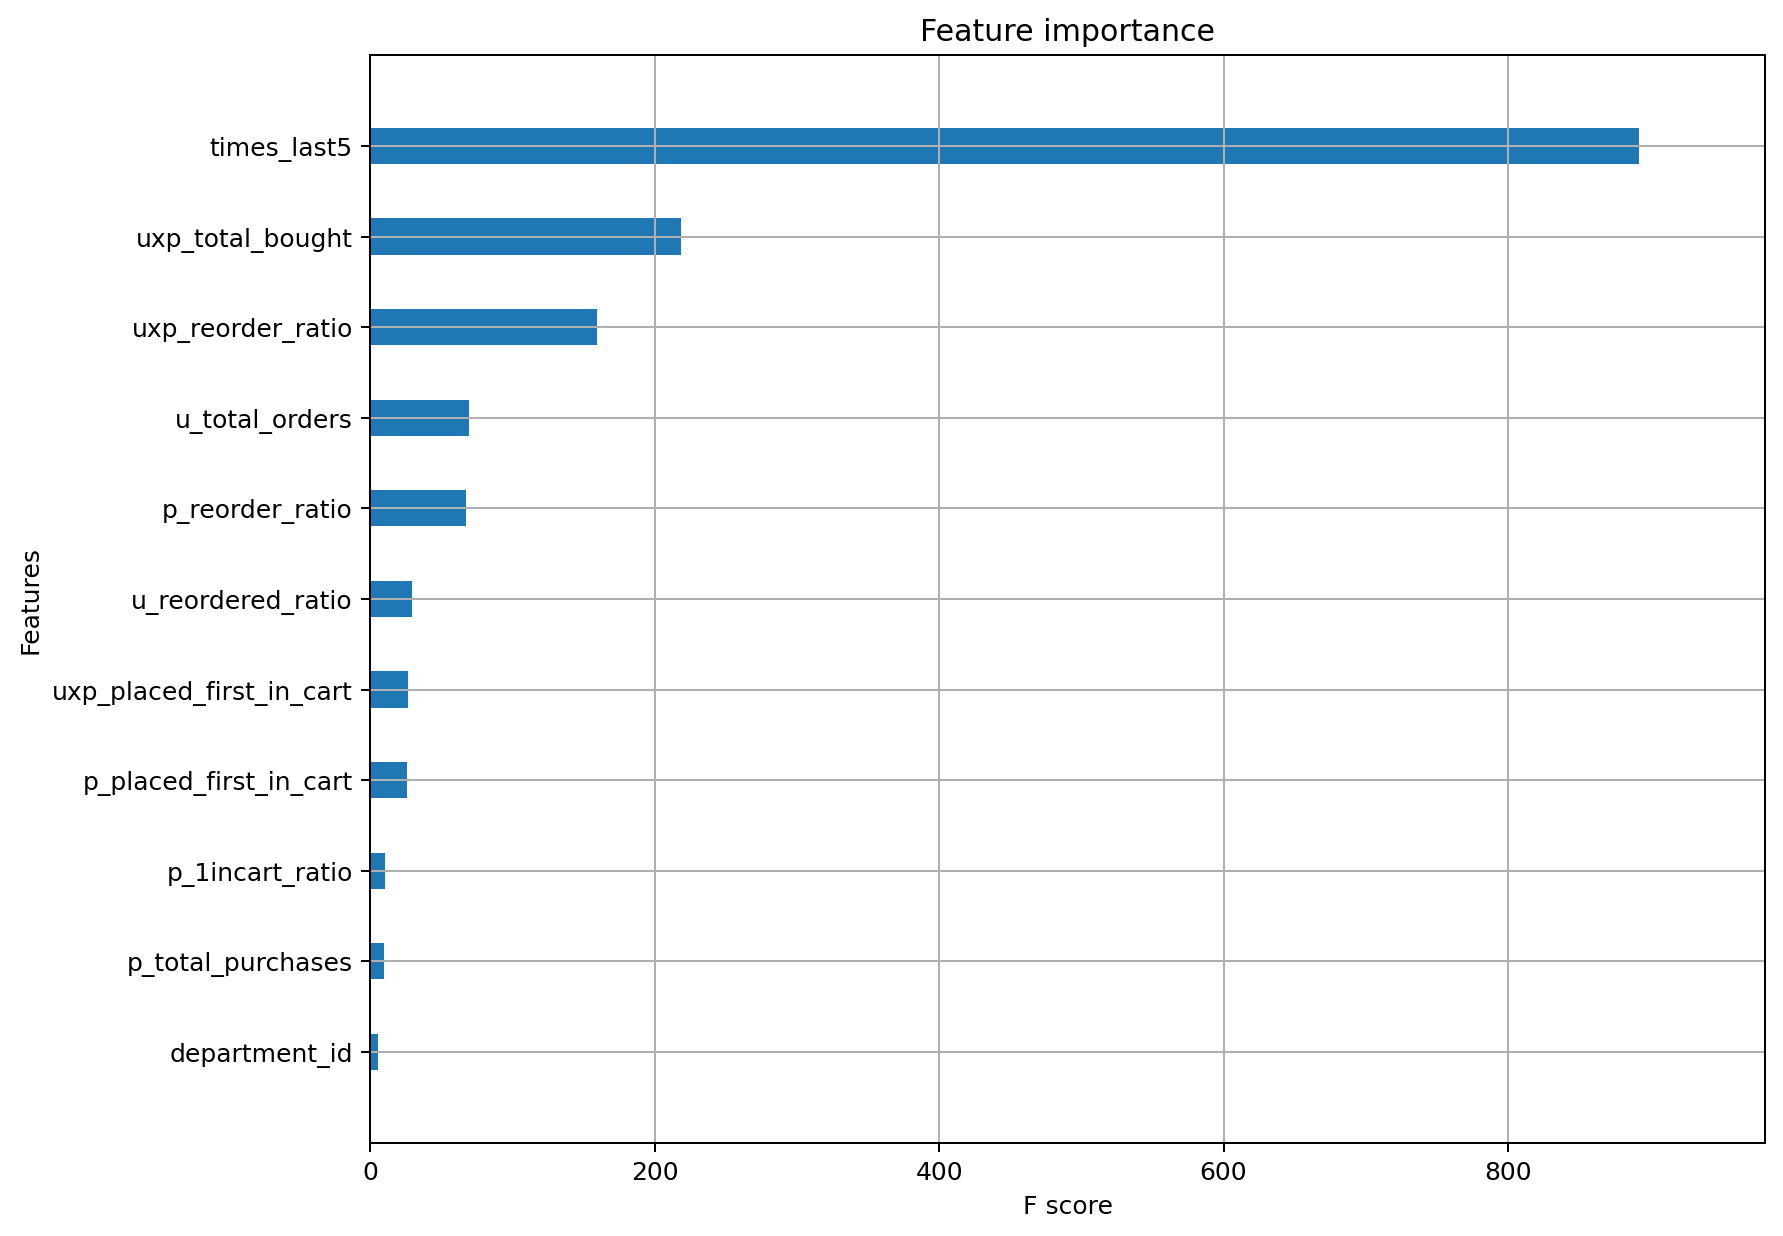

In [71]:
%matplotlib inline

fig, ax = pyplot.subplots(figsize=(10, 8), dpi=180)


plot_importance(best, height=0.4, importance_type='gain', max_num_features=30, show_values=False, ax=ax)

pyplot.show()